In [2]:
!pip install transformers datasets -Uq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.8.0 requires protobuf<5,>=4.21, but you have protobuf 3.20.3 which is incompatible.
cuml 23.8.0 requires dask==2023.7.1, but you have dask 2023.12.0 which is incompatible.
cuml 23.8.0 requires distributed==2023.7.1, but you have distributed 2023.12.0 which is incompatible.
dask-cuda 23.8.0 requires dask==2023.7.1, but you have dask 2023.12.0 which is incompatible.
dask-cuda 23.8.0 requires distributed==2023.7.1, but you have distributed 2023.12.0 which is incompatible.
dask-cuda 23.8.0 requires pandas<1.6.0dev0,

In [3]:
from datasets import load_metric, DatasetDict, Dataset, load_dataset


# define the dataset
datasets = load_dataset('Andyrasika/ShoeSandalBootimages')
datasets

Resolving data files:   0%|          | 0/15000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 15000
    })
})

In [3]:
from huggingface_hub import login
login()

## Splitting the data into train, test and validate

In [4]:
# split the dataset into train and test
datasets = datasets['train'].train_test_split(test_size=.2, seed=42)

# split the train dataset into train and validation
datasets_split = datasets['train'].train_test_split(test_size=.2, seed=42)

# defining the train datasets
datasets['train'] = datasets_split['train']

# defining the validation datasets
datasets['validation'] = datasets_split['test']

# get the labels
labels = datasets['train'].features['label'].names

datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 9600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2400
    })
})

## Data Exploratory


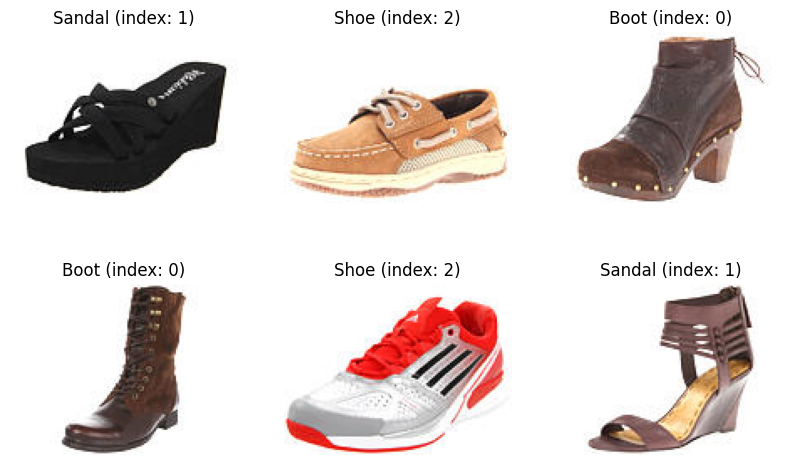

In [6]:
import matplotlib.pyplot as plt
# plot samples
def plot_samples(samples, labels):
    # the pointer variable is used to keep track of the current index of the samples
    pointer = 0

    fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
    for i in range(2):
        for j in range(3):
            ax[i,j].imshow(samples[pointer]['image'])
            ax[i,j].set_title(f"{labels[samples[pointer]['label']]} (index: {samples[pointer]['label']})")
            ax[i,j].axis('off')
            pointer+=1

    plt.show()

# Call the function
plot_samples(datasets['train'].select(range(6, 12)), labels)

We can see that:

- We have one picture per image.
- all the items are on the white font.
- All the images have the same resolution.

## Modeling with RESNET50

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from transformers import AutoFeatureExtractor, ResNetForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, DatasetDict, Dataset, load_dataset

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

# defining the model
resnet50_ckpt = 'microsoft/resnet-50'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


# define the feature extractor
resnet_extractor = AutoFeatureExtractor.from_pretrained(resnet50_ckpt)

# define the model
resnet_model = ResNetForImageClassification.from_pretrained(resnet50_ckpt,
                                                    num_labels=len(labels),
                                                    id2label={str(i): c for i, c in enumerate(labels)},
                                                    label2id={c: str(i) for i, c in enumerate(labels)},
                                                    ignore_mismatched_sizes=True)

resnet_model = resnet_model.to(device)

cuda:0


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([3, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The RESNET model need some preprocessing before using the model.

In [10]:
# preprocessing function
def resnet_batch_transform(examples):
    """
    Takes a batch of images and turn them into pixel values
    Outputs PyTorch tensors
    """
    # take a list of PIL images and turn into pixel values
    inputs = resnet_extractor([x for x in examples['image']], return_tensors='pt')

    # add the labels in
    inputs['label'] = examples['label']
    
    return inputs

# transform the data with resnet extractor
transformed_data = datasets.with_transform(resnet_batch_transform)

The transformed data can be used to fine tune the RESNET model. Fine-tuning can easily be applied using the Trainer function from the hugging face module.

In [12]:
!pip install wandb -q

In [15]:
batch_size = 16
logging_steps = len(transformed_data['train']) // batch_size
# data collator
def collate_fn(examples):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in examples]),
        'labels': torch.tensor([x['label'] for x in examples])
    }

# metrics
metric = load_metric('accuracy')
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1
    }

# define the training arguments
resnet50_args = TrainingArguments(output_dir=f"./kaggle/working/",
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=3,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True,)
# define the trainer
resnet50_trainer = Trainer(model=resnet_model,
                 args=resnet50_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=resnet_extractor)

# train the model
resnet50_trainer.train()

# evaluate
resnet50_trainer.evaluate(transformed_data['validation'])

# predictions
resnet_predictions = resnet50_trainer.predict(transformed_data['test'])

# convert the predictions to labels
resnet_pred = [labels[idx] for idx in resnet_predictions.predictions.argmax(axis=1).tolist()]

/opt/conda/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.049000,0.964890,0.438333,0.366716
2,0.897900,0.847594,0.621250,0.605771
3,0.840400,0.821385,0.647083,0.634023
